## DB1B

In [2]:
#Print the data structure

import pandas as pd
from pathlib import Path

data_dir = Path(".")
file_names = [
    "T_DB1B_TICKET.csv",
    "T_DB1B_MARKET.csv",
    "T_DB1B_COUPON.csv",
    "T_T100D_SEGMENT_ALL_CARRIER.csv"
]

for name in file_names:
    path = data_dir / name
    print("=" * 80)
    print(f"Loading file: {name}")
    
    try:
        df = pd.read_csv(path, nrows=5)  # read only a few rows
        print(f"✓ Loaded. Shape preview: {df.shape}")
        print("Columns:")
        for col in df.columns:
            print("  -", col)
    except Exception as e:
        print(f"✗ Error reading {name}: {e}")


Loading file: T_DB1B_TICKET.csv
✓ Loaded. Shape preview: (5, 12)
Columns:
  - ITIN_ID
  - COUPONS
  - YEAR
  - QUARTER
  - ORIGIN
  - ROUNDTRIP
  - ONLINE
  - DOLLAR_CRED
  - PASSENGERS
  - ITIN_FARE
  - MILES_FLOWN
  - ITIN_GEO_TYPE
Loading file: T_DB1B_MARKET.csv
✓ Loaded. Shape preview: (5, 17)
Columns:
  - ITIN_ID
  - MKT_ID
  - MARKET_COUPONS
  - YEAR
  - QUARTER
  - ORIGIN
  - DEST
  - REPORTING_CARRIER
  - TICKET_CARRIER
  - OPERATING_CARRIER
  - PASSENGERS
  - MARKET_FARE
  - MARKET_DISTANCE
  - MARKET_MILES_FLOWN
  - NONSTOP_MILES
  - ITIN_GEO_TYPE
  - MKT_GEO_TYPE
Loading file: T_DB1B_COUPON.csv
✓ Loaded. Shape preview: (5, 16)
Columns:
  - ITIN_ID
  - MKT_ID
  - SEQ_NUM
  - COUPONS
  - YEAR
  - QUARTER
  - ORIGIN
  - DEST
  - TICKET_CARRIER
  - OPERATING_CARRIER
  - REPORTING_CARRIER
  - PASSENGERS
  - FARE_CLASS
  - DISTANCE
  - ITIN_GEO_TYPE
  - COUPON_GEO_TYPE
Loading file: T_T100D_SEGMENT_ALL_CARRIER.csv
✓ Loaded. Shape preview: (5, 10)
Columns:
  - SEATS
  - PASSENGERS


In [3]:
# Merge 3 tables based on their unique ITIN_ID & MKT_ID

import pandas as pd


ticket = pd.read_csv("T_DB1B_TICKET.csv")
market = pd.read_csv("T_DB1B_MARKET.csv")
coupon = pd.read_csv("T_DB1B_COUPON.csv")
t100   = pd.read_csv("T_T100D_SEGMENT_ALL_CARRIER.csv")  # we will use this later

# Keep Direct = one coupon in the itinerary
ticket_direct = ticket[ticket["COUPONS"] == 1].copy()
market_direct = market[market["MARKET_COUPONS"] == 1].copy()
# keep the single segment (SEQ_NUM == 1) of those 1-coupon itineraries
coupon_direct = coupon[(coupon["COUPONS"] == 1) & (coupon["SEQ_NUM"] == 1)].copy()

# Merge Ticket + Market on ITIN_ID
db1b_tm = ticket_direct.merge(
    market_direct,
    on="ITIN_ID",
    how="inner",
    suffixes=("_TKT", "_MKT")
)

# From Coupon we only need fare class for cabin type
coupon_small = coupon_direct[["ITIN_ID", "MKT_ID", "FARE_CLASS"]].copy()

# Merge in FARE_CLASS using ITIN_ID + MKT_ID
db1b_master = db1b_tm.merge(
    coupon_small,
    on=["ITIN_ID", "MKT_ID"],
    how="left"
)

print("db1b_master shape:", db1b_master.shape)
print(db1b_master.head())


db1b_master shape: (817800, 29)
    ITIN_ID  COUPONS  YEAR_TKT  QUARTER_TKT ORIGIN_TKT  ROUNDTRIP  ONLINE  \
0  20241514        1      2024            1        EYW        0.0     1.0   
1  20241515        1      2024            1        EYW        0.0     1.0   
2  20241516        1      2024            1        EYW        0.0     1.0   
3  20241517        1      2024            1        EYW        0.0     1.0   
4  20241518        1      2024            1        EYW        0.0     1.0   

   DOLLAR_CRED  PASSENGERS_TKT  ITIN_FARE  ...  TICKET_CARRIER  \
0            1             1.0        0.0  ...              UA   
1            1             1.0       69.0  ...              3M   
2            1             2.0       77.0  ...              3M   
3            1             3.0       81.0  ...              UA   
4            1             6.0       89.0  ...              3M   

   OPERATING_CARRIER  PASSENGERS_MKT  MARKET_FARE  MARKET_DISTANCE  \
0                 3M             1.0  

In [4]:
df = db1b_master.copy()
before = len(df)
print("initial datapoint:", before)

initial datapoint: 817800


In [5]:
# Keep credible fares (DollarCred=1)

df = df[df["DOLLAR_CRED"] == 1]
_stepA = len(df)
print("Credible fares left:", _stepA)

Credible fares left: 808779


In [6]:
# Drop first/business class using FARE_CLASS

def is_coach(fc):
    if pd.isna(fc):
        return False
    c = str(fc).strip().upper()
    if c.startswith(("F", "G", "A", "C", "J", "D", "I")):
        return False
    return True

df = df[df["FARE_CLASS"].apply(is_coach)]
_stepB = len(df)
print("Coach-class left:", _stepB)

Coach-class left: 767523


In [7]:
# Remove frequent flyer / zero fares / tiny fares

df["ROUNDTRIP"] = df["ROUNDTRIP"].astype(float)

ff_mask = (
    (df["ITIN_FARE"] == 0) |
    ((df["ROUNDTRIP"] == 1) & (df["ITIN_FARE"] <= 20)) |
    ((df["ROUNDTRIP"] != 1) & (df["ITIN_FARE"] <= 10))
)

df = df[~ff_mask]
_stepC = len(df)
print("After removing FF/zero/tiny fares:", _stepC)

After removing FF/zero/tiny fares: 752792


In [8]:
# Remove codeshares

df = df[df["TICKET_CARRIER"] == df["OPERATING_CARRIER"]]
_stepD = len(df)
print("After removing codeshares:", _stepD)


After removing codeshares: 633970


In [9]:
# Make a copy
db1b_clean = df.copy()

# Standardize YEAR + QUARTER
if "YEAR_TKT" in db1b_clean.columns:
    db1b_clean["YEAR"] = db1b_clean["YEAR_TKT"]
if "QUARTER_TKT" in db1b_clean.columns:
    db1b_clean["QUARTER"] = db1b_clean["QUARTER_TKT"]

# Standardize ORIGIN + DEST
origin_candidates = ["ORIGIN", "ORIGIN_TKT", "ORIGIN_MKT"]
dest_candidates   = ["DEST", "DEST_TKT", "DEST_MKT"]

for c in origin_candidates:
    if c in db1b_clean.columns:
        db1b_clean["ORIGIN_ROUTE"] = db1b_clean[c]
        break

for c in dest_candidates:
    if c in db1b_clean.columns:
        db1b_clean["DEST_ROUTE"] = db1b_clean[c]
        break

# Standardize carrier
db1b_clean["CARRIER"] = db1b_clean["OPERATING_CARRIER"]

# Standardize fare variable
db1b_clean["FARE"] = db1b_clean["MARKET_FARE"]

# Print summary
print("FINAL DB1B CLEAN SHAPE:", db1b_clean.shape)
print("Origin column example:", db1b_clean["ORIGIN_ROUTE"].iloc[0])
print("Dest column example:", db1b_clean["DEST_ROUTE"].iloc[0])
db1b_clean.head()


FINAL DB1B CLEAN SHAPE: (633970, 35)
Origin column example: EYW
Dest column example: FLL


,ITIN_ID,COUPONS,YEAR_TKT,QUARTER_TKT,ORIGIN_TKT,ROUNDTRIP,ONLINE,DOLLAR_CRED,PASSENGERS_TKT,ITIN_FARE,...,NONSTOP_MILES,ITIN_GEO_TYPE_MKT,MKT_GEO_TYPE,FARE_CLASS,YEAR,QUARTER,ORIGIN_ROUTE,DEST_ROUTE,CARRIER,FARE
1,20241515,1,2024,1,EYW,0.0,1.0,1,1.0,69.0,...,145.0,2,2,Y,2024,1,EYW,FLL,3M,69.0
2,20241516,1,2024,1,EYW,0.0,1.0,1,2.0,77.0,...,145.0,2,2,X,2024,1,EYW,FLL,3M,77.0
4,20241518,1,2024,1,EYW,0.0,1.0,1,6.0,89.0,...,145.0,2,2,X,2024,1,EYW,FLL,3M,89.0
6,20241520,1,2024,1,EYW,0.0,1.0,1,1.0,99.0,...,145.0,2,2,X,2024,1,EYW,FLL,3M,99.0
7,20241521,1,2024,1,EYW,0.0,1.0,1,4.0,100.0,...,145.0,2,2,X,2024,1,EYW,FLL,3M,100.0


In [10]:
import numpy as np
import pandas as pd


def gini_unweighted(x):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return np.nan
    if np.all(x == 0):
        return 0.0
    x = np.sort(x)
    n = x.size
    i = np.arange(1, n + 1)
    return (2 * (i * x).sum() / (n * x.sum())) - (n + 1) / n

db1b_clean["fare_per_mile"] = db1b_clean["FARE"] / db1b_clean["NONSTOP_MILES"]

group_cols = ["YEAR", "QUARTER", "CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE"]

db1b_route = (
    db1b_clean
    .groupby(group_cols)
    .agg(
        n_tickets=("ITIN_ID", "count"),
        passengers_db1b=("PASSENGERS_TKT", "sum"),
        avg_fare=("FARE", "mean"),
        avg_fare_per_mile=("fare_per_mile", "mean"),
        gini=("FARE", gini_unweighted),
        gini_per_mile=("fare_per_mile", gini_unweighted),
        nonstop_miles=("NONSTOP_MILES", "first")
    )
    .reset_index()
)

print("db1b_route shape:", db1b_route.shape)
db1b_route.head()


db1b_route shape: (9323, 12)


,YEAR,QUARTER,CARRIER,ORIGIN_ROUTE,DEST_ROUTE,n_tickets,passengers_db1b,avg_fare,avg_fare_per_mile,gini,gini_per_mile,nonstop_miles
0,2024,1,3M,EYW,FLL,19,53.0,134.473684,0.927405,0.185601,0.185601,145.0
1,2024,1,3M,EYW,MCO,38,133.0,162.210526,0.605263,0.200084,0.200084,268.0
2,2024,1,3M,EYW,TPA,38,104.0,197.526316,0.823026,0.209811,0.209811,240.0
3,2024,1,3M,FLL,EYW,16,35.0,145.187500,1.001293,0.177814,0.177814,145.0
4,2024,1,3M,FLL,GNV,30,89.0,157.033333,0.558837,0.253117,0.253117,281.0


In [11]:
import numpy as np
import pandas as pd

df_g = db1b_route.copy()

#  clean invalid values
df_g = df_g.replace([np.inf, -np.inf], np.nan).dropna(subset=["gini"])

# keep only meaningful observations: at least 100 tickets
df_g = df_g[df_g["n_tickets"] >= 200]   


#  Top 10 highest Gini
top10 = df_g.sort_values("gini", ascending=False).head(10)

#  Bottom 10 lowest Gini
bottom10 = df_g.sort_values("gini", ascending=True).head(10)

print("=== Highest Gini (Top 10 carrier–routes) ===")
print(top10[["CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE", "n_tickets",
             "gini", "avg_fare"]])

print("\n=== Lowest Gini (Bottom 10 carrier–routes) ===")
print(bottom10[["CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE", "n_tickets",
               "gini", "avg_fare"]])


=== Highest Gini (Top 10 carrier–routes) ===
     CARRIER ORIGIN_ROUTE DEST_ROUTE  n_tickets      gini    avg_fare
6030      UA          SFO        KOA        203  0.434131  443.147783
5556      UA          LAX        HNL        354  0.424245  444.776836
5641      UA          MIA        SFO        329  0.421801  486.392097
6037      UA          SFO        MIA        286  0.418333  433.863636
4064      HA          HNL        LAX        298  0.417071  400.208054
5522      UA          KOA        LAX        221  0.416890  540.194570
2208      DL          LAX        MCO        337  0.414015  459.344214
2102      DL          HNL        LAX        236  0.413787  496.300847
5082      UA          BOS        SFO        431  0.409544  538.744780
5524      UA          KOA        SFO        215  0.402668  442.967442

=== Lowest Gini (Bottom 10 carrier–routes) ===
     CARRIER ORIGIN_ROUTE DEST_ROUTE  n_tickets      gini    avg_fare
8629      WN          SAN        PHX        203  0.245511  194.7586

Regression: gini = -0.000014 * nonstop_miles + 0.267796


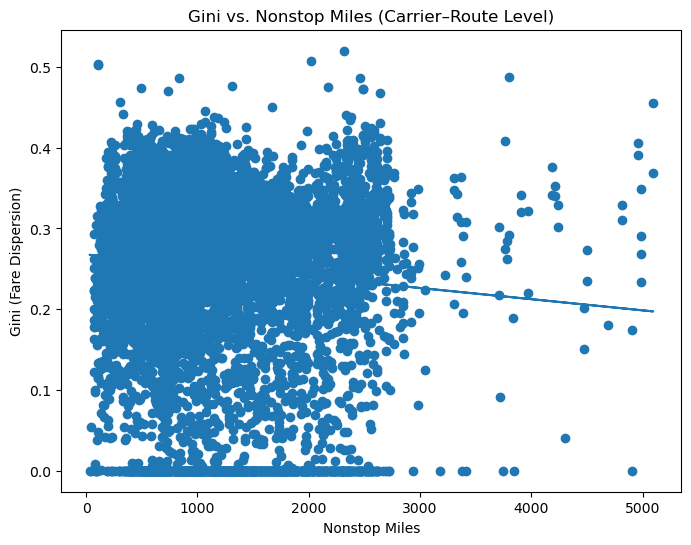

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# prepare data
df_plot = db1b_route.copy()
df_plot = df_plot.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot.dropna(subset=["gini", "nonstop_miles"])

X = df_plot["nonstop_miles"].values
y = df_plot["gini"].values

# simple OLS (numpy)
coef = np.polyfit(X, y, 1)
line = coef[0] * X + coef[1]

print("Regression: gini = {:.6f} * nonstop_miles + {:.6f}".format(coef[0], coef[1]))

# plotting
plt.figure(figsize=(8,6))
plt.scatter(X, y)
plt.plot(X, line)
plt.xlabel("Nonstop Miles")
plt.ylabel("Gini (Fare Dispersion)")
plt.title("Gini vs. Nonstop Miles (Carrier–Route Level)")
plt.show()


## T100 Table 

In [13]:
t = t100.copy()

keep_cols = [
    "YEAR", "QUARTER", "MONTH",
    "CARRIER",
    "ORIGIN", "DEST",
    "PASSENGERS", "DISTANCE"
]

t = t[keep_cols].copy()

# Keep passenger-carrying segments
t = t[t["PASSENGERS"] > 0].copy()

print("T100 cleaned shape:", t.shape)
t.head()


T100 cleaned shape: (366919, 8)


,YEAR,QUARTER,MONTH,CARRIER,ORIGIN,DEST,PASSENGERS,DISTANCE
45128,2024,2,4,8C,LAX,RNO,9.0,391.0
45537,2024,2,5,7S,RSH,RSH,1.0,0.0
45538,2024,2,6,7S,RSH,RSH,1.0,0.0
45539,2024,2,6,7S,SLQ,RDV,1.0,9.0
45540,2024,3,7,7S,CHU,ANI,1.0,11.0


In [14]:
# Group by carrier–route–quarter
group_cols_t = ["YEAR", "QUARTER", "CARRIER", "ORIGIN", "DEST"]

t100_carrier_route = (
    t
    .groupby(group_cols_t)
    .agg(
        passengers_t100=("PASSENGERS", "sum"),
        distance_t100=("DISTANCE", "mean")
    )
    .reset_index()
)

print("t100_carrier_route shape:", t100_carrier_route.shape)
t100_carrier_route.head()


t100_carrier_route shape: (92963, 7)


,YEAR,QUARTER,CARRIER,ORIGIN,DEST,passengers_t100,distance_t100
0,2024,1,02Q,AUS,MIA,1.0,1103.0
1,2024,1,02Q,KOA,GUM,44.0,3928.0
2,2024,1,04Q,2GA,RSW,3.0,355.0
3,2024,1,04Q,2GA,SUA,3.0,369.0
4,2024,1,04Q,3FL,TMB,4.0,157.0


In [15]:
route_keys = ["YEAR", "QUARTER", "ORIGIN", "DEST"]

# total passenger count on each ROUTE (sum across carriers)
t100_carrier_route["route_total_passengers"] = (
    t100_carrier_route
    .groupby(route_keys)["passengers_t100"]
    .transform("sum")
)

# carrier's market share
t100_carrier_route["share"] = (
    t100_carrier_route["passengers_t100"] /
    t100_carrier_route["route_total_passengers"]
)

t100_carrier_route.head()


,YEAR,QUARTER,CARRIER,ORIGIN,DEST,passengers_t100,distance_t100,route_total_passengers,share
0,2024,1,02Q,AUS,MIA,1.0,1103.0,62375.0,0.000016
1,2024,1,02Q,KOA,GUM,44.0,3928.0,44.0,1.000000
2,2024,1,04Q,2GA,RSW,3.0,355.0,3.0,1.000000
3,2024,1,04Q,2GA,SUA,3.0,369.0,3.0,1.000000
4,2024,1,04Q,3FL,TMB,4.0,157.0,4.0,1.000000


In [16]:
t100_carrier_route["HHI"] = (
    t100_carrier_route
    .groupby(route_keys)["share"]
    .transform(lambda s: (s ** 2).sum())
)

print("Sample HHI rows:")
t100_carrier_route.head()


Sample HHI rows:


,YEAR,QUARTER,CARRIER,ORIGIN,DEST,passengers_t100,distance_t100,route_total_passengers,share,HHI
0,2024,1,02Q,AUS,MIA,1.0,1103.0,62375.0,0.000016,0.565555
1,2024,1,02Q,KOA,GUM,44.0,3928.0,44.0,1.000000,1.000000
2,2024,1,04Q,2GA,RSW,3.0,355.0,3.0,1.000000,1.000000
3,2024,1,04Q,2GA,SUA,3.0,369.0,3.0,1.000000,1.000000
4,2024,1,04Q,3FL,TMB,4.0,157.0,4.0,1.000000,1.000000


In [17]:
merge_cols = ["YEAR", "QUARTER", "CARRIER", "ORIGIN_ROUTE", "DEST_ROUTE"]

# prepare T100 for merge (rename ORIGIN/DEST to match db1b_route)
t100_merge_ready = t100_carrier_route.rename(
    columns={
        "ORIGIN": "ORIGIN_ROUTE",
        "DEST": "DEST_ROUTE"
    }
)

db1b_panel = db1b_route.merge(
    t100_merge_ready[
        ["YEAR","QUARTER","CARRIER","ORIGIN_ROUTE","DEST_ROUTE",
         "passengers_t100","route_total_passengers","share","HHI",
         "distance_t100"]
    ],
    on=merge_cols,
    how="inner"
)

print("Final merged dataset shape:", db1b_panel.shape)
db1b_panel.head()


Final merged dataset shape: (7633, 17)


,YEAR,QUARTER,CARRIER,ORIGIN_ROUTE,DEST_ROUTE,n_tickets,passengers_db1b,avg_fare,avg_fare_per_mile,gini,gini_per_mile,nonstop_miles,passengers_t100,route_total_passengers,share,HHI,distance_t100
0,2024,1,3M,EYW,FLL,19,53.0,134.473684,0.927405,0.185601,0.185601,145.0,2432.0,2737.0,0.888564,0.800951,145.0
1,2024,1,3M,EYW,MCO,38,133.0,162.210526,0.605263,0.200084,0.200084,268.0,4925.0,5184.0,0.950039,0.905069,268.0
2,2024,1,3M,EYW,TPA,38,104.0,197.526316,0.823026,0.209811,0.209811,240.0,6549.0,7026.0,0.932109,0.873437,240.0
3,2024,1,3M,FLL,EYW,16,35.0,145.187500,1.001293,0.177814,0.177814,145.0,1999.0,2144.0,0.932369,0.872989,145.0
4,2024,1,3M,FLL,GNV,30,89.0,157.033333,0.558837,0.253117,0.253117,281.0,1992.0,1992.0,1.000000,1.000000,281.0


In [18]:
import statsmodels.formula.api as smf

reg = smf.ols(
    "gini ~ HHI + np.log(nonstop_miles)",
    data=db1b_panel
).fit()

print(reg.summary())


                            OLS Regression Results                            
Dep. Variable:                   gini   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     247.5
Date:                Mon, 17 Nov 2025   Prob (F-statistic):          6.97e-105
Time:                        14:38:42   Log-Likelihood:                 10004.
No. Observations:                7633   AIC:                        -2.000e+04
Df Residuals:                    7630   BIC:                        -1.998e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.20

In [19]:
# collapse db1b_panel to route-level
route_keys = ["YEAR", "QUARTER", "ORIGIN_ROUTE", "DEST_ROUTE"]

d = db1b_panel.copy()

# keep valid entries
d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=["gini", "HHI", "passengers_db1b"])

# weighted gini at route level
route_panel = (
    d
    .assign(weight=lambda x: x["passengers_db1b"])
    .groupby(route_keys)
    .apply(lambda g: pd.Series({
        "HHI": g["HHI"].iloc[0],    # same for all carriers
        "nonstop_miles": g["nonstop_miles"].iloc[0],
        "route_total_passengers": g["route_total_passengers"].iloc[0],
        
        # weighted average Gini
        "gini_route_weighted": np.average(g["gini"], weights=g["weight"]),
        
        # average fare per mile weighted
        "avg_fare_per_mile_route": np.average(g["avg_fare_per_mile"], weights=g["weight"]),
        
        # number of carriers on that route
        "n_carriers": g.shape[0],
    }))
    .reset_index()
)

print("Route-level panel shape:", route_panel.shape)
route_panel.head()


Route-level panel shape: (5075, 10)


C:\Users\Jared Zheng\AppData\Local\Temp\ipykernel_30856\3765027854.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,YEAR,QUARTER,ORIGIN_ROUTE,DEST_ROUTE,HHI,nonstop_miles,route_total_passengers,gini_route_weighted,avg_fare_per_mile_route,n_carriers
0,2024,1,ABE,BNA,1.0,685.0,3143.0,0.301333,0.095377,1.0
1,2024,1,ABE,DEN,1.0,1539.0,3399.0,0.287757,0.054084,1.0
2,2024,1,ABE,FLL,1.0,1041.0,4616.0,0.317254,0.131501,1.0
3,2024,1,ABE,MLB,1.0,914.0,3448.0,0.355581,0.126281,1.0
4,2024,1,ABE,MYR,1.0,518.0,3858.0,0.327524,0.169112,1.0


In [28]:
#  Add lat/lon for ORIGIN_ROUTE and DEST_ROUTE using airports.dat 

import pandas as pd

# 1. Download airports.dat
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

colnames = [
    "id", "name", "city", "country",
    "iata", "icao", "lat", "lon",
    "alt", "tz", "dst", "tz_db",
    "type", "source"
]

air = pd.read_csv(
    url, header=None, names=colnames, dtype=str
)

# 2. Convert lat/lon to numeric
air["lat"] = pd.to_numeric(air["lat"], errors="coerce")
air["lon"] = pd.to_numeric(air["lon"], errors="coerce")

# 3. Keep valid IATA 3-letter codes
air = air.dropna(subset=["iata", "lat", "lon"])
air = air[air["iata"].str.len() == 3]

# 4. Coordinates lookup table
air_loc = air[["iata", "lat", "lon"]].copy()
air_loc.columns = ["IATA", "lat", "lon"]

# 5. Merge origin coordinates
route_panel = route_panel.merge(
    air_loc,
    left_on="ORIGIN_ROUTE",
    right_on="IATA",
    how="left"
).rename(columns={"lat": "lat_org", "lon": "lon_org"}).drop(columns=["IATA"])

# 6. Merge destination coordinates
route_panel = route_panel.merge(
    air_loc,
    left_on="DEST_ROUTE",
    right_on="IATA",
    how="left"
).rename(columns={"lat": "lat_dest", "lon": "lon_dest"}).drop(columns=["IATA"])

print("Route panel with coordinates:", route_panel.shape)
route_panel.head()


Route panel with coordinates: (5075, 14)


,YEAR,QUARTER,ORIGIN_ROUTE,DEST_ROUTE,HHI,nonstop_miles,route_total_passengers,gini_route_weighted,avg_fare_per_mile_route,n_carriers,lat_org,lon_org,lat_dest,lon_dest
0,2024,1,ABE,BNA,1.0,685.0,3143.0,0.301333,0.095377,1.0,40.6521,-75.440804,36.124500,-86.678200
1,2024,1,ABE,DEN,1.0,1539.0,3399.0,0.287757,0.054084,1.0,40.6521,-75.440804,39.861698,-104.672997
2,2024,1,ABE,FLL,1.0,1041.0,4616.0,0.317254,0.131501,1.0,40.6521,-75.440804,26.072599,-80.152702
3,2024,1,ABE,MLB,1.0,914.0,3448.0,0.355581,0.126281,1.0,40.6521,-75.440804,28.102800,-80.645302
4,2024,1,ABE,MYR,1.0,518.0,3858.0,0.327524,0.169112,1.0,40.6521,-75.440804,33.679699,-78.928299


In [30]:
! pip install cartopy

     ---------------------------------------- 0.0/64.9 kB ? eta -:--:--
     ---------------------------------------- 64.9/64.9 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.2/11.0 MB 5.3 MB/s eta 0:00:03
   - -------------------------------------- 0.5/11.0 MB 5.9 MB/s eta 0:00:02
   --- ------------------------------------ 1.0/11.0 MB 7.7 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.0 MB 7.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.9/11.0 MB 8.7 MB/s eta 0:00:02
   --------- ------------------------------ 2.5/11.0 MB 9.5 MB/s eta 0:00:01
   ----------- ---------------------------- 3.1/11.0 MB 9.3 MB/s eta 0:00:01
   ------------- -------------------------- 3.7/11.0 MB 9.7 MB/s eta 0:00:01
   -------------- ------------------------- 4.0/11.0 MB 9.5 MB/s eta 0:00:01
   ---------------- ----------------------- 4.5/11.0 MB 9.5 MB/s eta 0:00:01
   -----

## Graph Drawing

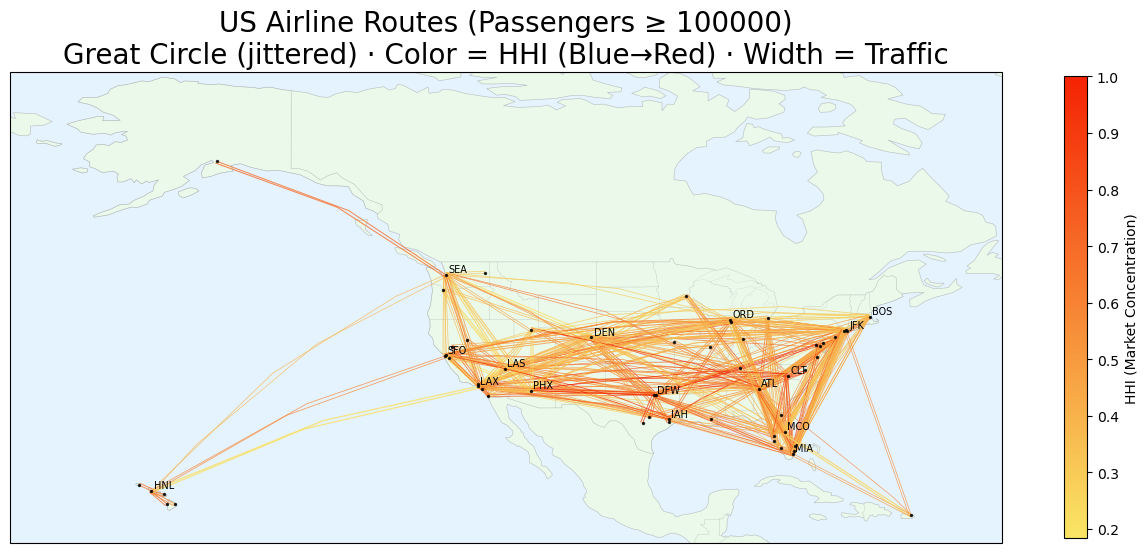

In [ ]:
# ===== US Airline Route Map: Warm HHI Gradient + Small Airport Dots ===== 

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap

PASSENGER_MIN = 100000

rp = route_panel.query("route_total_passengers >= @PASSENGER_MIN").copy()

proj = ccrs.PlateCarree()

plt.figure(figsize=(16, 10))
ax = plt.axes(projection=proj)

# === Map background: land green, ocean blue ===
ax.add_feature(cfeature.LAND,  facecolor="#d6f5d6", alpha=0.5)   
ax.add_feature(cfeature.OCEAN, facecolor="#cde8ff", alpha=0.5)   
ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="gray", alpha=0.5)
ax.add_feature(cfeature.BORDERS,   linewidth=0.3, edgecolor="gray", alpha=0.4)
ax.add_feature(cfeature.STATES,    linewidth=0.2, edgecolor="gray", alpha=0.3)

ax.set_extent([-175, -55, 15, 72], crs=proj)

hhi_cmap = LinearSegmentedColormap.from_list(
    "hhi_cmap",
    ["#f9e665", "#f52303"]  # 蓝 -> 红
)

norm = Normalize(vmin=rp["HHI"].min(), vmax=rp["HHI"].max())


rp = rp.copy()
rp["pair_id"] = rp.apply(
    lambda r: tuple(sorted([r["ORIGIN_ROUTE"], r["DEST_ROUTE"]])),
    axis=1
)
rp["pair_idx"] = rp.groupby("pair_id").cumcount()  # 0,1,2,...

# Scale width by passengers
max_pax = rp["route_total_passengers"].max()


OFFSET_STEP = 0.25  

# Draw routes
for _, row in rp.iterrows():
    lat_o, lon_o = row["lat_org"], row["lon_org"]
    lat_d, lon_d = row["lat_dest"], row["lon_dest"]
    dx = lon_d - lon_o
    dy = lat_d - lat_o
    length = np.hypot(dx, dy)
    if length == 0:
        ux, uy = 0.0, 0.0
    else:
        ux = -dy / length
        uy =  dx / length

    k = int(row["pair_idx"])
    if k == 0:
        offset_scale = 0
    else:
        offset_scale = ((k + 1) // 2) * (1 if k % 2 == 1 else -1)

    offset = OFFSET_STEP * offset_scale

    lon_o_shift = lon_o + offset * ux
    lat_o_shift = lat_o + offset * uy
    lon_d_shift = lon_d + offset * ux
    lat_d_shift = lat_d + offset * uy

    color = hhi_cmap(norm(row["HHI"]))
    lw = 0.2 + 1.0 * (row["route_total_passengers"] / max_pax)

    ax.plot(
        [lon_o_shift, lon_d_shift],
        [lat_o_shift, lat_d_shift],
        transform=ccrs.Geodetic(),  
        color=color,
        linewidth=lw,
        alpha=0.8
    )

# ===== Colorbar for HHI =====
sm = plt.cm.ScalarMappable(cmap=hhi_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label("HHI (Market Concentration)")

plt.title(
    f"US Airline Routes (Passengers ≥ {PASSENGER_MIN})\n"
    f"Great Circle (jittered) · Color = HHI (Blue→Red) · Width = Traffic",
    fontsize=20
)

# ====== Label Top Airports (with NYC & Florida filtering + small font) ======

N = 20   # number of major hubs to label
FONT_SIZE = 7  # smaller font

# 1. total pax per airport
airport_pax = (
    pd.concat([
        rp.groupby("ORIGIN_ROUTE")["route_total_passengers"].sum(),
        rp.groupby("DEST_ROUTE")["route_total_passengers"].sum()
    ])
    .groupby(level=0).sum()
)

# 2. top-N airport list
top_airports = airport_pax.sort_values(ascending=False).head(N).index.tolist()

# 3. airport coordinate table
airports = pd.DataFrame({
    "iata": pd.concat([rp["ORIGIN_ROUTE"], rp["DEST_ROUTE"]]),
    "lat":  pd.concat([rp["lat_org"], rp["lat_dest"]]),
    "lon":  pd.concat([rp["lon_org"], rp["lon_dest"]])
}).drop_duplicates()

# 4. ---- Region Filters --------------------------------------------------

def is_nyc(iata):
    return iata in ["JFK", "LGA", "EWR"]  # we keep only JFK

def is_florida(lat, lon):
    return 24 < lat < 31 and -88 < lon < -78

nyc_main = "JFK"
fl_main = ["MCO", "MIA"]

# -------------------------------------------------------------------------

# smaller airport dots
ax.scatter(
    airports["lon"], airports["lat"],
    color="black", s=2, alpha=0.8,      
    transform=proj, zorder=5
)

for _, row in airports.iterrows():
    iata = row["iata"]
    lat = row["lat"]
    lon = row["lon"]

    if iata not in top_airports:
        continue
    if is_nyc(iata) and iata != nyc_main:
        continue
    if is_florida(lat, lon) and iata not in fl_main:
        continue

    ax.text(
        lon + 0.3,
        lat + 0.3,
        iata,
        fontsize=FONT_SIZE,
        color="black",
        transform=proj,
        zorder=6
    )

plt.show()


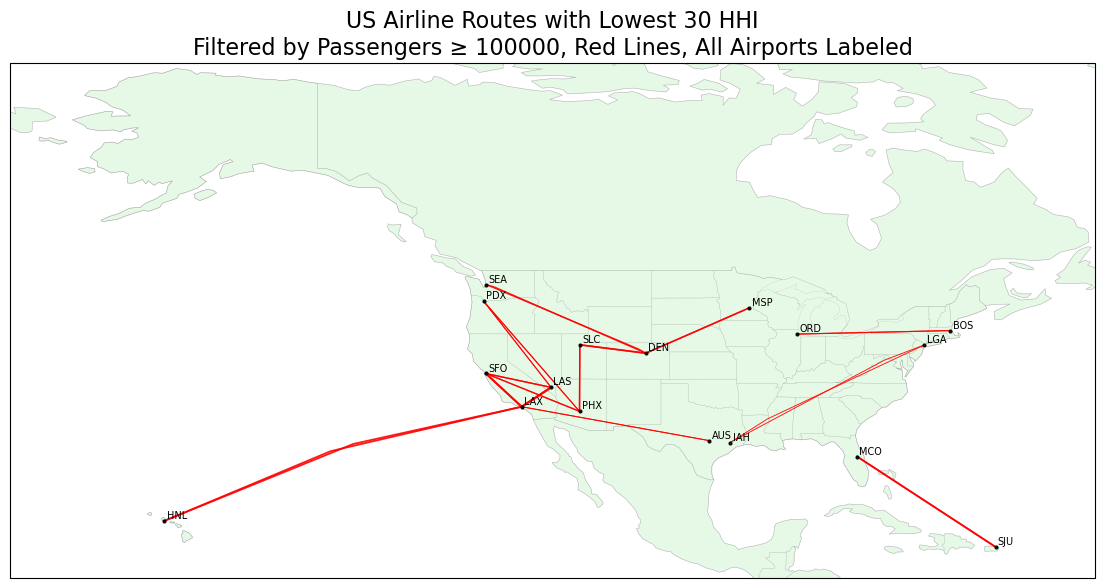

In [ ]:
# ===== Block: 100 Routes with Lowest HHI (Passengers cutoff, red lines, all airport labels) =====

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


rp_low = (
    route_panel
    .query("route_total_passengers >= @PASSENGER_MIN")
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=["HHI", "lat_org", "lon_org", "lat_dest", "lon_dest"])
    .sort_values("HHI", ascending=True)
    .head(30)
    .copy()
)

proj = ccrs.PlateCarree()

plt.figure(figsize=(14, 9))
ax = plt.axes(projection=proj)


ax.add_feature(cfeature.LAND,  facecolor="#d6f5d6", alpha=0.6)
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", alpha=1.0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="gray", alpha=0.6)
ax.add_feature(cfeature.BORDERS,   linewidth=0.3, edgecolor="gray", alpha=0.5)
ax.add_feature(cfeature.STATES,    linewidth=0.2, edgecolor="gray", alpha=0.4)

ax.set_extent([-175, -55, 15, 72], crs=proj)


max_pax_low = rp_low["route_total_passengers"].max()

for _, row in rp_low.iterrows():
    lat_o, lon_o = row["lat_org"], row["lon_org"]
    lat_d, lon_d = row["lat_dest"], row["lon_dest"]

    lw = 0.3 + 1.2 * (row["route_total_passengers"] / max_pax_low)

    ax.plot(
        [lon_o, lon_d],
        [lat_o, lat_d],
        transform=ccrs.Geodetic(),
        color="red",     
        linewidth=lw,
        alpha=0.9
    )


airports_low = pd.DataFrame({
    "iata": pd.concat([rp_low["ORIGIN_ROUTE"], rp_low["DEST_ROUTE"]]),
    "lat":  pd.concat([rp_low["lat_org"], rp_low["lat_dest"]]),
    "lon":  pd.concat([rp_low["lon_org"], rp_low["lon_dest"]])
}).drop_duplicates()


ax.scatter(
    airports_low["lon"], airports_low["lat"],
    color="black", s=4, alpha=0.9,  
    transform=proj, zorder=5
)


for _, r in airports_low.iterrows():
    ax.text(
        r["lon"] + 0.25,
        r["lat"] + 0.25,
        r["iata"],
        fontsize=7,
        color="black",
        transform=proj,
        zorder=6
    )

plt.title(
    f"US Airline Routes with Lowest 30 HHI\n"
    f"Filtered by Passengers ≥ {PASSENGER_MIN}, Red Lines, All Airports Labeled",
    fontsize=16
)

plt.show()


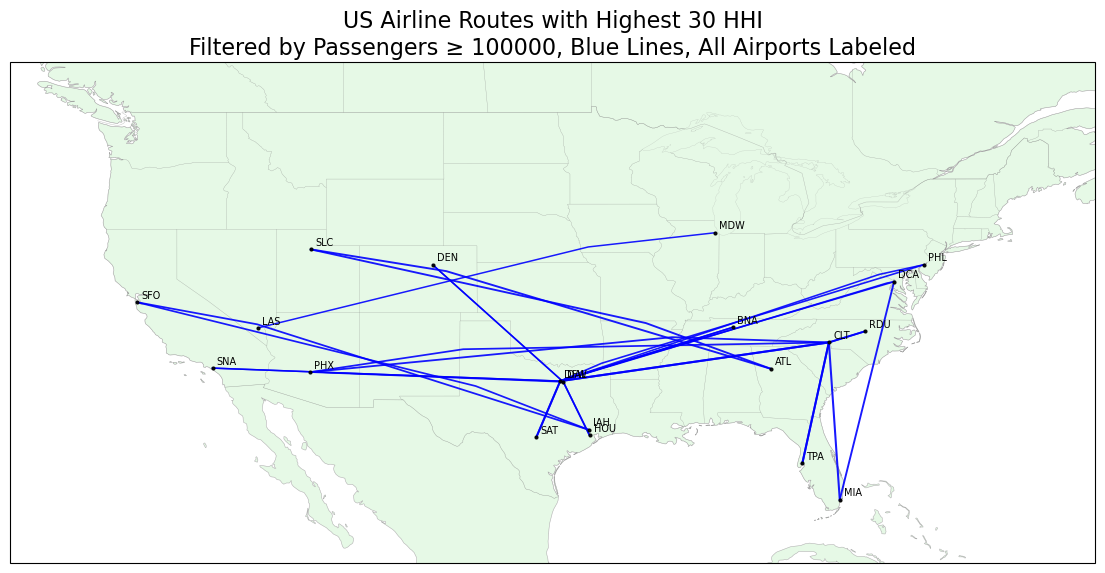

In [ ]:
# ===== Block: 50 Routes with Highest HHI (Passengers cutoff, blue lines, all airport labels) =====

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


rp_high = (
    route_panel
    .query("route_total_passengers >= @PASSENGER_MIN")
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=["HHI", "lat_org", "lon_org", "lat_dest", "lon_dest"])
    .sort_values("HHI", ascending=False)
    .head(30)
    .copy()
)

proj = ccrs.PlateCarree()

plt.figure(figsize=(14, 9))
ax = plt.axes(projection=proj)


ax.add_feature(cfeature.LAND,  facecolor="#d6f5d6", alpha=0.6)
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", alpha=1.0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="gray", alpha=0.6)
ax.add_feature(cfeature.BORDERS,   linewidth=0.3, edgecolor="gray", alpha=0.5)
ax.add_feature(cfeature.STATES,    linewidth=0.2, edgecolor="gray", alpha=0.4)


ax.set_extent([-130, -65, 22, 52], crs=proj)


max_pax_high = rp_high["route_total_passengers"].max()

for _, row in rp_high.iterrows():
    lat_o, lon_o = row["lat_org"], row["lon_org"]
    lat_d, lon_d = row["lat_dest"], row["lon_dest"]

    lw = 0.3 + 1.2 * (row["route_total_passengers"] / max_pax_high)

    ax.plot(
        [lon_o, lon_d],
        [lat_o, lat_d],
        transform=ccrs.Geodetic(),
        color="blue",     
        linewidth=lw,
        alpha=0.9
    )


airports_high = pd.DataFrame({
    "iata": pd.concat([rp_high["ORIGIN_ROUTE"], rp_high["DEST_ROUTE"]]),
    "lat":  pd.concat([rp_high["lat_org"], rp_high["lat_dest"]]),
    "lon":  pd.concat([rp_high["lon_org"], rp_high["lon_dest"]])
}).drop_duplicates()


ax.scatter(
    airports_high["lon"], airports_high["lat"],
    color="black", s=4, alpha=0.9,
    transform=proj, zorder=5
)


for _, r in airports_high.iterrows():
    ax.text(
        r["lon"] + 0.25,
        r["lat"] + 0.25,
        r["iata"],
        fontsize=7,
        color="black",
        transform=proj,
        zorder=6
    )

plt.title(
    f"US Airline Routes with Highest 30 HHI\n"
    f"Filtered by Passengers ≥ {PASSENGER_MIN}, Blue Lines, All Airports Labeled",
    fontsize=16
)

plt.show()


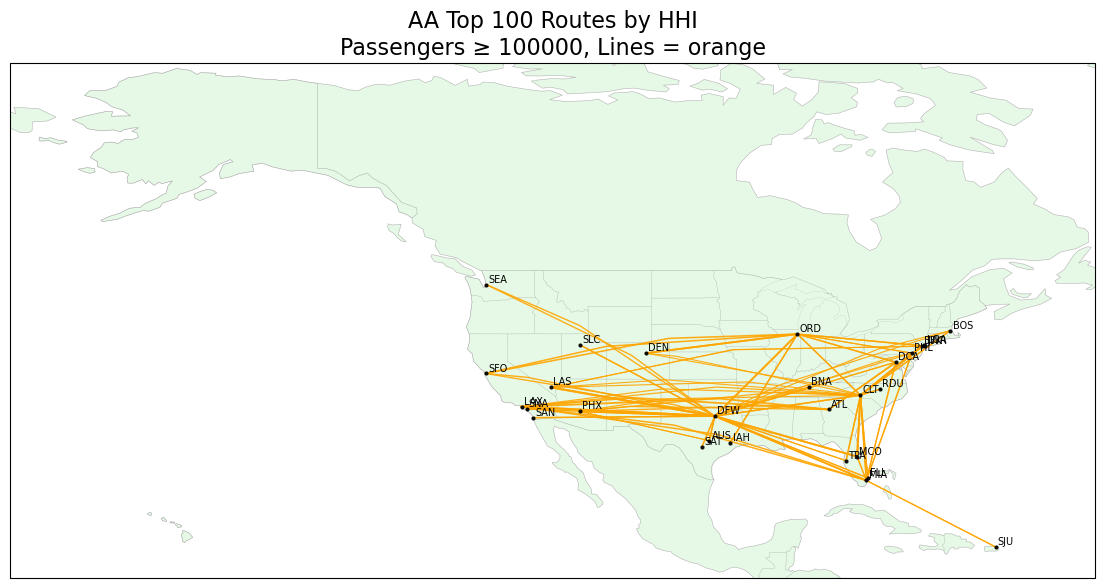

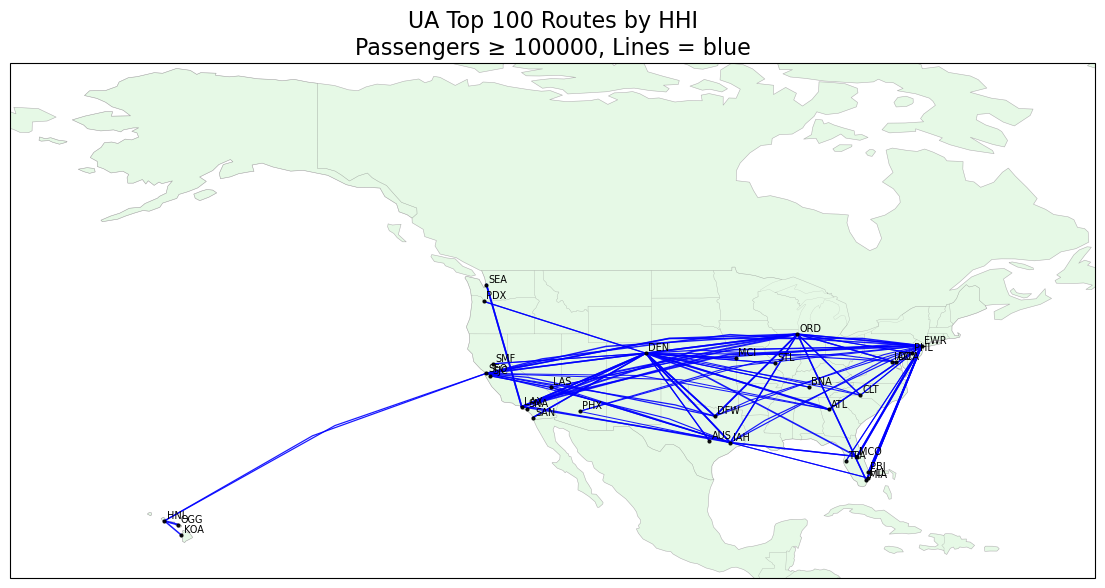

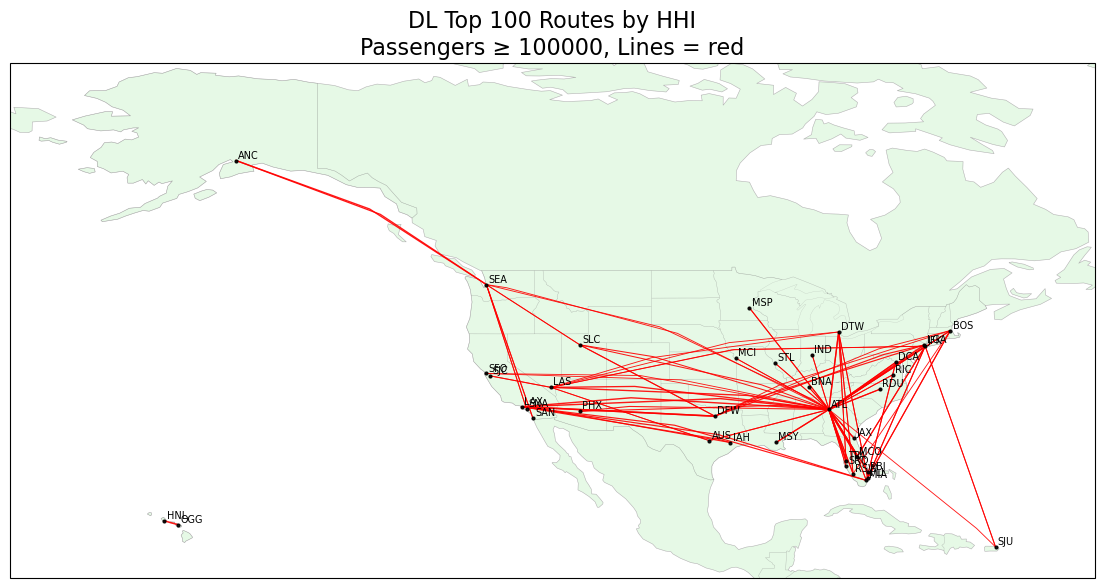

In [ ]:
# ===== Block: AA / UA / DL Top 100 HHI Routes (with Alaska + Hawaii) =====

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

N_TOP = 100 


route_coords = (
    route_panel[["ORIGIN_ROUTE", "DEST_ROUTE",
                 "lat_org", "lon_org", "lat_dest", "lon_dest"]]
    .drop_duplicates()
)

def plot_topN_for_carrier(carrier_code, line_color, n_top=N_TOP):
    df = (
        db1b_panel
        .query("CARRIER == @carrier_code and route_total_passengers >= @PASSENGER_MIN")
        .replace([np.inf, -np.inf], np.nan)
        .dropna(subset=["HHI"])
        .sort_values("HHI", ascending=False)
        .head(n_top)
        .copy()
    )


    df = df.merge(
        route_coords,
        on=["ORIGIN_ROUTE", "DEST_ROUTE"],
        how="left"
    ).dropna(subset=["lat_org", "lon_org", "lat_dest", "lon_dest"])

    proj = ccrs.PlateCarree()
    plt.figure(figsize=(14, 9))
    ax = plt.axes(projection=proj)

  
    ax.set_extent([-175, -55, 15, 72], crs=proj)

   
    ax.add_feature(cfeature.LAND,  facecolor="#d6f5d6", alpha=0.6)
    ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", alpha=1.0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="gray", alpha=0.6)
    ax.add_feature(cfeature.BORDERS,   linewidth=0.3, edgecolor="gray", alpha=0.5)
    ax.add_feature(cfeature.STATES,    linewidth=0.2, edgecolor="gray", alpha=0.4)


    max_pax = df["route_total_passengers"].max()

    for _, row in df.iterrows():
        lat_o, lon_o = row["lat_org"], row["lon_org"]
        lat_d, lon_d = row["lat_dest"], row["lon_dest"]

        lw = 0.3 + 1.2 * (row["route_total_passengers"] / max_pax)

        ax.plot(
            [lon_o, lon_d],
            [lat_o, lat_d],
            transform=ccrs.Geodetic(),
            color=line_color,
            linewidth=lw,
            alpha=0.9
        )

    
    airports = pd.DataFrame({
        "iata": pd.concat([df["ORIGIN_ROUTE"], df["DEST_ROUTE"]]),
        "lat":  pd.concat([df["lat_org"], df["lat_dest"]]),
        "lon":  pd.concat([df["lon_org"], df["lon_dest"]])
    }).drop_duplicates()

  
    ax.scatter(
        airports["lon"], airports["lat"],
        color="black", s=4, alpha=0.9,
        transform=proj, zorder=5
    )


    for _, r in airports.iterrows():
        ax.text(
            r["lon"] + 0.25,
            r["lat"] + 0.25,
            r["iata"],
            fontsize=7,
            color="black",
            transform=proj,
            zorder=6
        )

    plt.title(
        f"{carrier_code} Top {n_top} Routes by HHI\n"
        f"Passengers ≥ {PASSENGER_MIN}, Lines = {line_color}",
        fontsize=16
    )
    plt.show()



plot_topN_for_carrier("AA", "orange", n_top=N_TOP)
plot_topN_for_carrier("UA", "blue",   n_top=N_TOP)
plot_topN_for_carrier("DL", "red",    n_top=N_TOP)


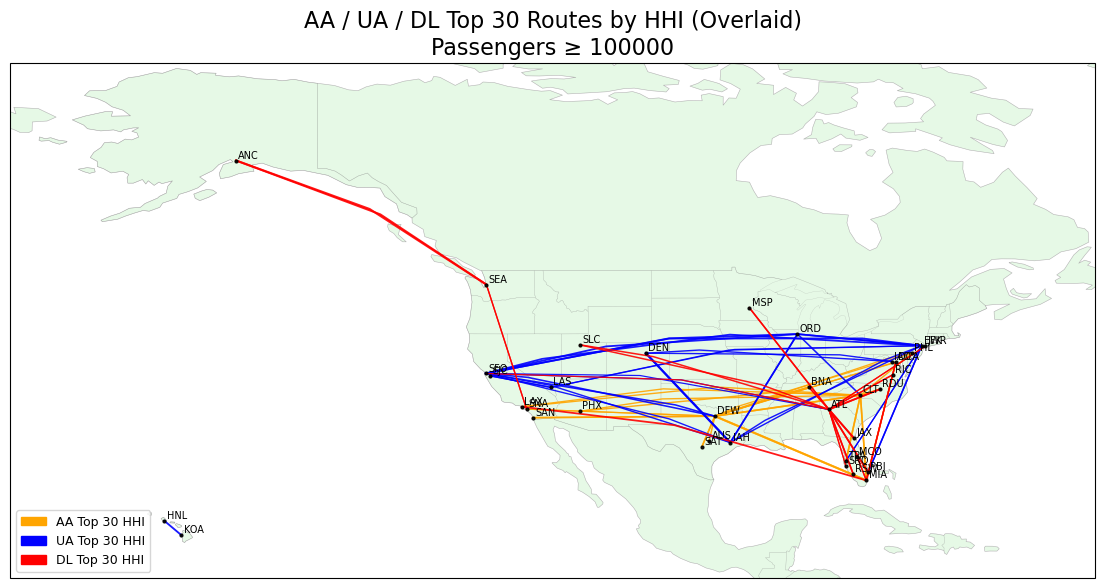

In [ ]:
# ===== Block: Overlay AA / UA / DL Top 10 HHI Routes on One Map =====

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

TOP_N = 30


route_coords = (
    route_panel[["ORIGIN_ROUTE", "DEST_ROUTE",
                 "lat_org", "lon_org", "lat_dest", "lon_dest"]]
    .drop_duplicates()
)

def get_topN_for_carrier(carrier_code, n_top=TOP_N):
    df = (
        db1b_panel
        .query("CARRIER == @carrier_code and route_total_passengers >= @PASSENGER_MIN")
        .replace([np.inf, -np.inf], np.nan)
        .dropna(subset=["HHI"])
        .sort_values("HHI", ascending=False)
        .head(n_top)
        .copy()
    )
    df = df.merge(
        route_coords,
        on=["ORIGIN_ROUTE", "DEST_ROUTE"],
        how="left"
    ).dropna(subset=["lat_org", "lon_org", "lat_dest", "lon_dest"])
    return df

df_aa = get_topN_for_carrier("AA", TOP_N)
df_ua = get_topN_for_carrier("UA", TOP_N)
df_dl = get_topN_for_carrier("DL", TOP_N)

proj = ccrs.PlateCarree()
plt.figure(figsize=(14, 9))
ax = plt.axes(projection=proj)


ax.set_extent([-175, -55, 15, 72], crs=proj)


ax.add_feature(cfeature.LAND,  facecolor="#d6f5d6", alpha=0.6)
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", alpha=1.0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="gray", alpha=0.6)
ax.add_feature(cfeature.BORDERS,   linewidth=0.3, edgecolor="gray", alpha=0.5)
ax.add_feature(cfeature.STATES,    linewidth=0.2, edgecolor="gray", alpha=0.4)


max_pax_all = max(
    df_aa["route_total_passengers"].max() if not df_aa.empty else 0,
    df_ua["route_total_passengers"].max() if not df_ua.empty else 0,
    df_dl["route_total_passengers"].max() if not df_dl.empty else 0,
)

def plot_df(df, color):
    if df.empty:
        return
    for _, row in df.iterrows():
        lat_o, lon_o = row["lat_org"], row["lon_org"]
        lat_d, lon_d = row["lat_dest"], row["lon_dest"]

        lw = 0.3 + 1.2 * (row["route_total_passengers"] / max_pax_all)

        ax.plot(
            [lon_o, lon_d],
            [lat_o, lat_d],
            transform=ccrs.Geodetic(),
            color=color,
            linewidth=lw,
            alpha=0.9
        )


plot_df(df_aa, "orange")
plot_df(df_ua, "blue")
plot_df(df_dl, "red")


airports_all = pd.DataFrame({
    "iata": pd.concat([df_aa["ORIGIN_ROUTE"], df_aa["DEST_ROUTE"],
                       df_ua["ORIGIN_ROUTE"], df_ua["DEST_ROUTE"],
                       df_dl["ORIGIN_ROUTE"], df_dl["DEST_ROUTE"]]),
    "lat":  pd.concat([df_aa["lat_org"], df_aa["lat_dest"],
                       df_ua["lat_org"], df_ua["lat_dest"],
                       df_dl["lat_org"], df_dl["lat_dest"]]),
    "lon":  pd.concat([df_aa["lon_org"], df_aa["lon_dest"],
                       df_ua["lon_org"], df_ua["lon_dest"],
                       df_dl["lon_org"], df_dl["lon_dest"]])
}).drop_duplicates()

ax.scatter(
    airports_all["lon"], airports_all["lat"],
    color="black", s=4, alpha=0.9,
    transform=proj, zorder=5
)

for _, r in airports_all.iterrows():
    ax.text(
        r["lon"] + 0.25,
        r["lat"] + 0.25,
        r["iata"],
        fontsize=7,
        color="black",
        transform=proj,
        zorder=6
    )


legend_handles = [
    Patch(color="orange", label="AA Top 30 HHI"),
    Patch(color="blue",   label="UA Top 30 HHI"),
    Patch(color="red",    label="DL Top 30 HHI"),
]
ax.legend(handles=legend_handles, loc="lower left", fontsize=9)

plt.title(
    f"AA / UA / DL Top {TOP_N} Routes by HHI (Overlaid)\n"
    f"Passengers ≥ {PASSENGER_MIN}",
    fontsize=16
)

plt.show()


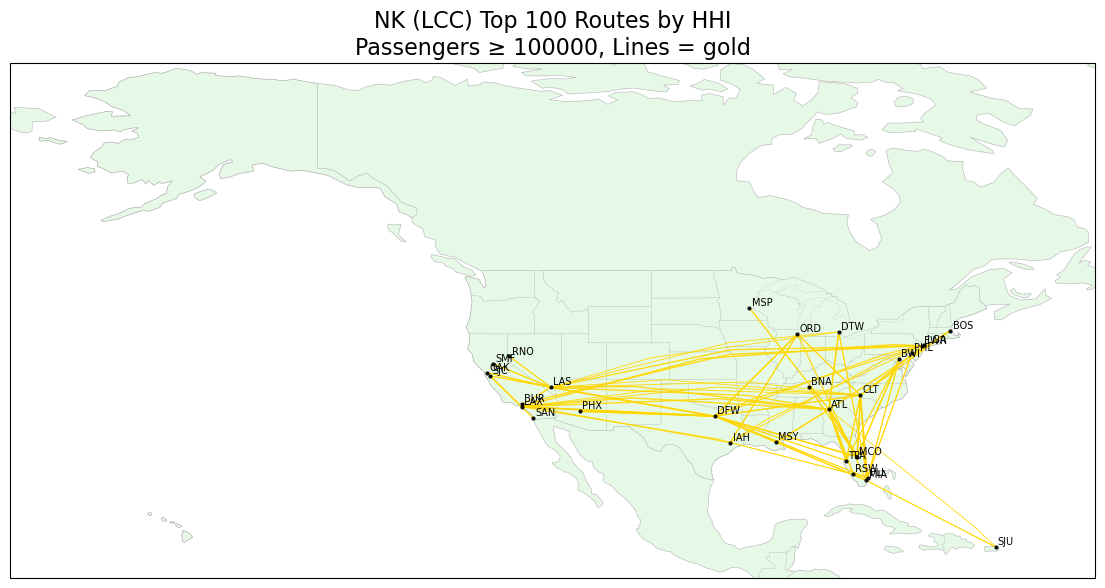

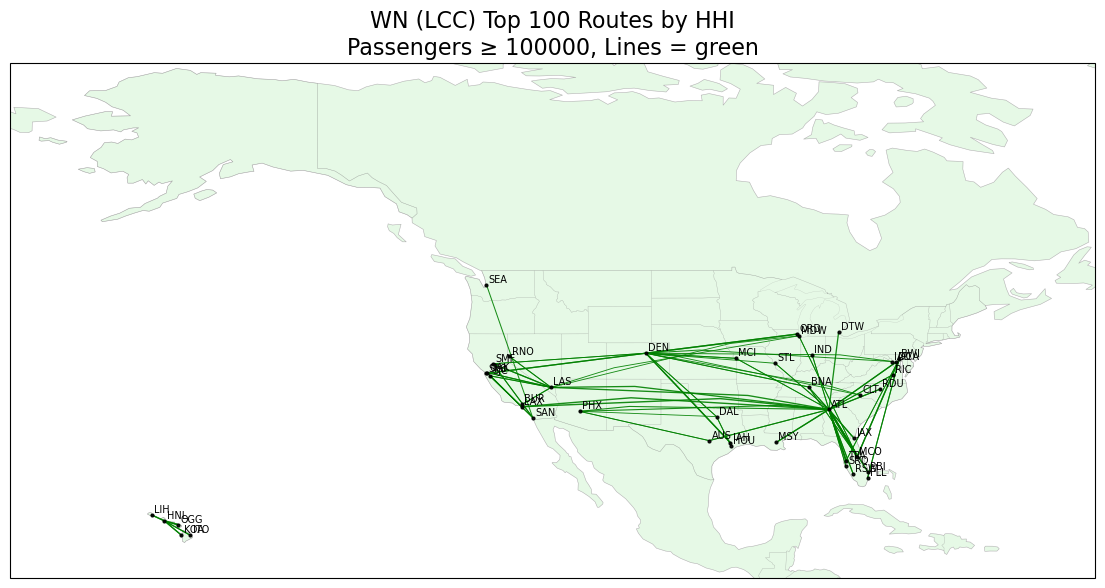

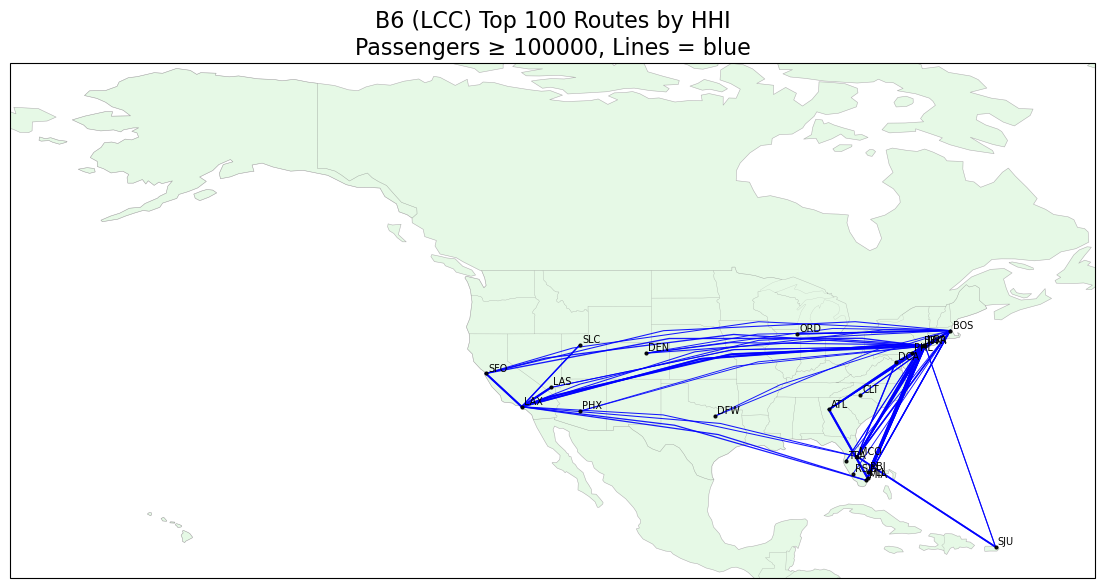

In [ ]:
# ===== Block: NK / F9 / B6 Top 100 HHI Routes (with Alaska + Hawaii) =====

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

N_TOP_LCC = 100  


route_coords = (
    route_panel[["ORIGIN_ROUTE", "DEST_ROUTE",
                 "lat_org", "lon_org", "lat_dest", "lon_dest"]]
    .drop_duplicates()
)

def plot_topN_for_lcc(carrier_code, line_color, n_top=N_TOP_LCC):
    df = (
        db1b_panel
        .query("CARRIER == @carrier_code and route_total_passengers >= @PASSENGER_MIN")
        .replace([np.inf, -np.inf], np.nan)
        .dropna(subset=["HHI"])
        .sort_values("HHI", ascending=False)
        .head(n_top)
        .copy()
    )


    df = df.merge(
        route_coords,
        on=["ORIGIN_ROUTE", "DEST_ROUTE"],
        how="left"
    ).dropna(subset=["lat_org", "lon_org", "lat_dest", "lon_dest"])

    proj = ccrs.PlateCarree()
    plt.figure(figsize=(14, 9))
    ax = plt.axes(projection=proj)


    ax.set_extent([-175, -55, 15, 72], crs=proj)


    ax.add_feature(cfeature.LAND,  facecolor="#d6f5d6", alpha=0.6)
    ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", alpha=1.0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="gray", alpha=0.6)
    ax.add_feature(cfeature.BORDERS,   linewidth=0.3, edgecolor="gray", alpha=0.5)
    ax.add_feature(cfeature.STATES,    linewidth=0.2, edgecolor="gray", alpha=0.4)


    max_pax = df["route_total_passengers"].max()

    for _, row in df.iterrows():
        lat_o, lon_o = row["lat_org"], row["lon_org"]
        lat_d, lon_d = row["lat_dest"], row["lon_dest"]

        lw = 0.3 + 1.2 * (row["route_total_passengers"] / max_pax)

        ax.plot(
            [lon_o, lon_d],
            [lat_o, lat_d],
            transform=ccrs.Geodetic(),
            color=line_color,
            linewidth=lw,
            alpha=0.9
        )


    airports = pd.DataFrame({
        "iata": pd.concat([df["ORIGIN_ROUTE"], df["DEST_ROUTE"]]),
        "lat":  pd.concat([df["lat_org"], df["lat_dest"]]),
        "lon":  pd.concat([df["lon_org"], df["lon_dest"]])
    }).drop_duplicates()

 
    ax.scatter(
        airports["lon"], airports["lat"],
        color="black", s=4, alpha=0.9,
        transform=proj, zorder=5
    )


    for _, r in airports.iterrows():
        ax.text(
            r["lon"] + 0.25,
            r["lat"] + 0.25,
            r["iata"],
            fontsize=7,
            color="black",
            transform=proj,
            zorder=6
        )

    plt.title(
        f"{carrier_code} (LCC) Top {n_top} Routes by HHI\n"
        f"Passengers ≥ {PASSENGER_MIN}, Lines = {line_color}",
        fontsize=16
    )
    plt.show()


plot_topN_for_lcc("NK", "gold",   n_top=N_TOP_LCC)   # Spirit
plot_topN_for_lcc("F9", "green",  n_top=N_TOP_LCC)   # Frontier
plot_topN_for_lcc("B6", "blue",   n_top=N_TOP_LCC)   # JetBlue


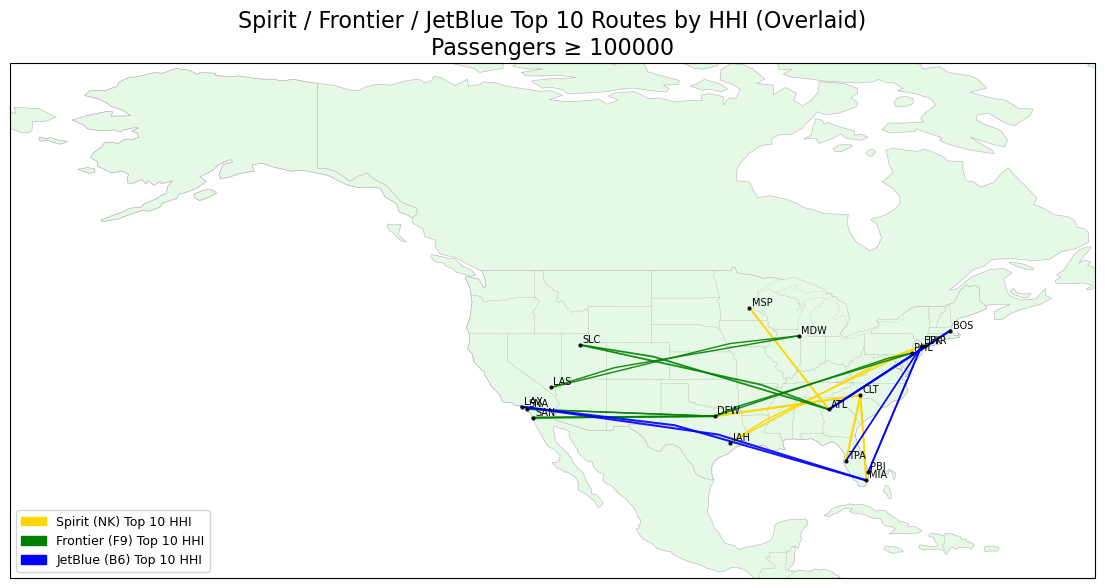

In [ ]:
# ===== Block: Overlay NK / F9 / B6 Top 10 HHI Routes on One Map =====

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

TOP_N_LCC = 10


route_coords = (
    route_panel[["ORIGIN_ROUTE", "DEST_ROUTE",
                 "lat_org", "lon_org", "lat_dest", "lon_dest"]]
    .drop_duplicates()
)

def get_topN_for_lcc(carrier_code, n_top=TOP_N_LCC):
    df = (
        db1b_panel
        .query("CARRIER == @carrier_code and route_total_passengers >= @PASSENGER_MIN")
        .replace([np.inf, -np.inf], np.nan)
        .dropna(subset=["HHI"])
        .sort_values("HHI", ascending=False)   # ⭐ Top HHI
        .head(n_top)
        .copy()
    )
    df = df.merge(
        route_coords,
        on=["ORIGIN_ROUTE", "DEST_ROUTE"],
        how="left"
    ).dropna(subset=["lat_org", "lon_org", "lat_dest", "lon_dest"])
    return df

df_nk = get_topN_for_lcc("NK", TOP_N_LCC)  # Spirit
df_f9 = get_topN_for_lcc("F9", TOP_N_LCC)  # Frontier
df_b6 = get_topN_for_lcc("B6", TOP_N_LCC)  # JetBlue

proj = ccrs.PlateCarree()
plt.figure(figsize=(14, 9))
ax = plt.axes(projection=proj)


ax.set_extent([-175, -55, 15, 72], crs=proj)


ax.add_feature(cfeature.LAND,  facecolor="#d6f5d6", alpha=0.6)
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff", alpha=1.0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4, edgecolor="gray", alpha=0.6)
ax.add_feature(cfeature.BORDERS,   linewidth=0.3, edgecolor="gray", alpha=0.5)
ax.add_feature(cfeature.STATES,    linewidth=0.2, edgecolor="gray", alpha=0.4)

max_pax_all_lcc = max(
    df_nk["route_total_passengers"].max() if not df_nk.empty else 0,
    df_f9["route_total_passengers"].max() if not df_f9.empty else 0,
    df_b6["route_total_passengers"].max() if not df_b6.empty else 0,
)

def plot_df(df, color):
    if df.empty or max_pax_all_lcc == 0:
        return
    for _, row in df.iterrows():
        lat_o, lon_o = row["lat_org"], row["lon_org"]
        lat_d, lon_d = row["lat_dest"], row["lon_dest"]

        lw = 0.3 + 1.2 * (row["route_total_passengers"] / max_pax_all_lcc)

        ax.plot(
            [lon_o, lon_d],
            [lat_o, lat_d],
            transform=ccrs.Geodetic(),
            color=color,
            linewidth=lw,
            alpha=0.9
        )


plot_df(df_nk, "gold")
plot_df(df_f9, "green")
plot_df(df_b6, "blue")


airports_all_lcc = pd.DataFrame({
    "iata": pd.concat([
        df_nk["ORIGIN_ROUTE"], df_nk["DEST_ROUTE"],
        df_f9["ORIGIN_ROUTE"], df_f9["DEST_ROUTE"],
        df_b6["ORIGIN_ROUTE"], df_b6["DEST_ROUTE"]
    ]),
    "lat":  pd.concat([
        df_nk["lat_org"], df_nk["lat_dest"],
        df_f9["lat_org"], df_f9["lat_dest"],
        df_b6["lat_org"], df_b6["lat_dest"]
    ]),
    "lon":  pd.concat([
        df_nk["lon_org"], df_nk["lon_dest"],
        df_f9["lon_org"], df_f9["lon_dest"],
        df_b6["lon_org"], df_b6["lon_dest"]
    ])
}).drop_duplicates()

ax.scatter(
    airports_all_lcc["lon"], airports_all_lcc["lat"],
    color="black", s=4, alpha=0.9,
    transform=proj, zorder=5
)

for _, r in airports_all_lcc.iterrows():
    ax.text(
        r["lon"] + 0.25,
        r["lat"] + 0.25,
        r["iata"],
        fontsize=7,
        color="black",
        transform=proj,
        zorder=6
    )


legend_handles = [
    Patch(color="gold",  label="Spirit (NK) Top 10 HHI"),
    Patch(color="green", label="Frontier (F9) Top 10 HHI"),
    Patch(color="blue",  label="JetBlue (B6) Top 10 HHI"),
]
ax.legend(handles=legend_handles, loc="lower left", fontsize=9)

plt.title(
    f"Spirit / Frontier / JetBlue Top {TOP_N_LCC} Routes by HHI (Overlaid)\n"
    f"Passengers ≥ {PASSENGER_MIN}",
    fontsize=16
)

plt.show()


In [ ]:
import numpy as np
import pandas as pd

df_r = route_panel.copy()

# Threshold
min_passengers = 1000
min_carriers   = 5   

df_r = df_r[
    (df_r["route_total_passengers"] >= min_passengers) &
    (df_r["n_carriers"] >= min_carriers)
]

print("Remaining routes after filter:", df_r.shape[0])

# Top 10 competitive (lowest HHI)
top10_routes = (
    df_r.sort_values("HHI", ascending=True)
        .head(10)
)

# Top 10 concentrated (highest HHI)
bottom10_routes = (
    df_r.sort_values("HHI", ascending=False)
        .head(10)
)

print("=== MOST COMPETITIVE 10 Routes (lowest HHI) ===")
print(top10_routes[[
    "ORIGIN_ROUTE", "DEST_ROUTE", "HHI", "gini_route_weighted",
    "avg_fare_per_mile_route", "nonstop_miles", "n_carriers",
    "route_total_passengers"
]])

print("\n=== MOST CONCENTRATED 10 Routes (highest HHI) ===")
print(bottom10_routes[[
    "ORIGIN_ROUTE", "DEST_ROUTE", "HHI", "gini_route_weighted",
    "avg_fare_per_mile_route", "nonstop_miles", "n_carriers",
    "route_total_passengers"
]])


Remaining routes after filter: 57
=== MOST COMPETITIVE 10 Routes (lowest HHI) ===
     ORIGIN_ROUTE DEST_ROUTE       HHI  gini_route_weighted  \
2402          LAS        LAX  0.183205             0.344518   
2506          LAX        LAS  0.184035             0.348527   
2518          LAX        OGG  0.202335             0.393936   
2499          LAX        HNL  0.203657             0.369381   
1882          HNL        LAX  0.206452             0.383073   
3262          OGG        LAX  0.209910             0.363955   
4480          SFO        PHX  0.211628             0.319745   
3735          PHX        SFO  0.212746             0.320260   
4467          SFO        LAX  0.228360             0.333422   
4317          SEA        DEN  0.236020             0.326781   

      avg_fare_per_mile_route  nonstop_miles  n_carriers  \
2402                 0.735573          236.0         7.0   
2506                 0.720546          236.0         7.0   
2518                 0.132053         2486.0

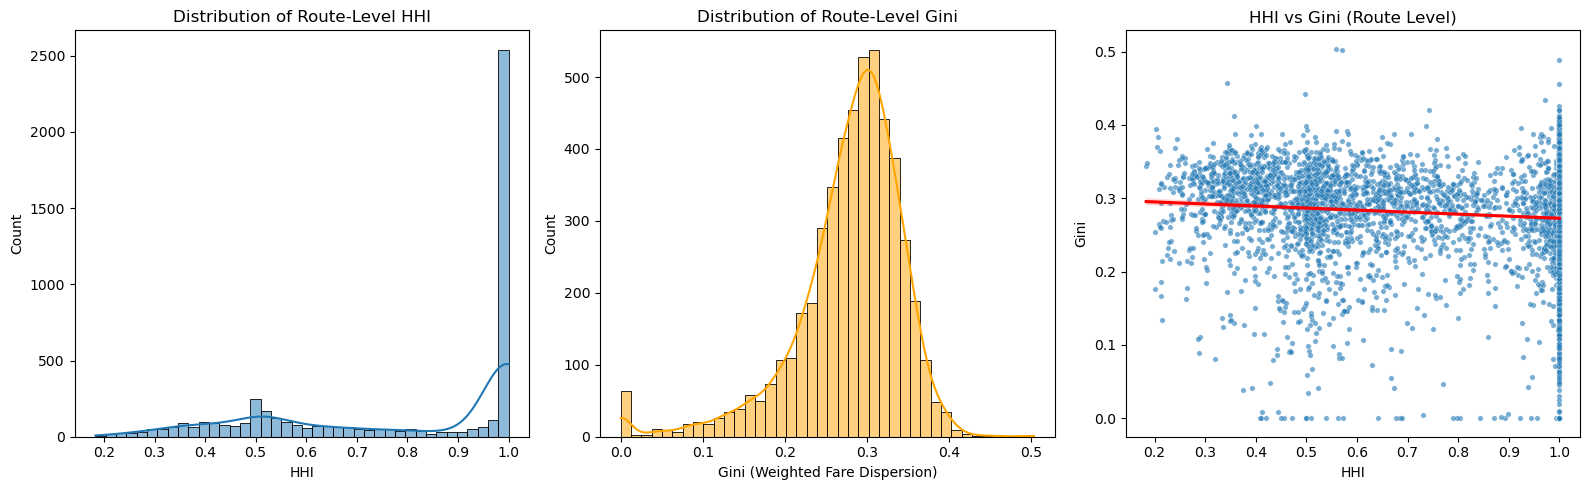

Min HHI: 0.18320468434523998
Median HHI: 0.9798995082754709
Max HHI: 1.0

Min Gini: 0.0
Median Gini: 0.29030962324677967
Max Gini: 0.5037037037037038

Total routes: 5075


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_r = route_panel.copy()
df_r = df_r.replace([np.inf, -np.inf], np.nan).dropna(subset=["HHI", "gini_route_weighted"])

plt.figure(figsize=(16,5))

# -----------------------------
# Subplot 1: HHI Histogram + KDE
# -----------------------------
plt.subplot(1,3,1)
sns.histplot(df_r["HHI"], kde=True, bins=40)
plt.title("Distribution of Route-Level HHI")
plt.xlabel("HHI")

# -----------------------------
# Subplot 2: Gini Histogram + KDE
# -----------------------------
plt.subplot(1,3,2)
sns.histplot(df_r["gini_route_weighted"], kde=True, bins=40, color='orange')
plt.title("Distribution of Route-Level Gini")
plt.xlabel("Gini (Weighted Fare Dispersion)")

# -----------------------------
# Subplot 3: Scatter HHI vs Gini
# -----------------------------
plt.subplot(1,3,3)
sns.scatterplot(x="HHI", y="gini_route_weighted", data=df_r, s=15, alpha=0.6)
sns.regplot(x="HHI", y="gini_route_weighted", data=df_r, scatter=False, color="red")
plt.title("HHI vs Gini (Route Level)")
plt.xlabel("HHI")
plt.ylabel("Gini")

plt.tight_layout()
plt.show()

print("Min HHI:", df_r["HHI"].min())
print("Median HHI:", df_r["HHI"].median())
print("Max HHI:", df_r["HHI"].max())

print("\nMin Gini:", df_r["gini_route_weighted"].min())
print("Median Gini:", df_r["gini_route_weighted"].median())
print("Max Gini:", df_r["gini_route_weighted"].max())

print("\nTotal routes:", len(df_r))


Remaining routes with HHI ≤ 0.8: 2123


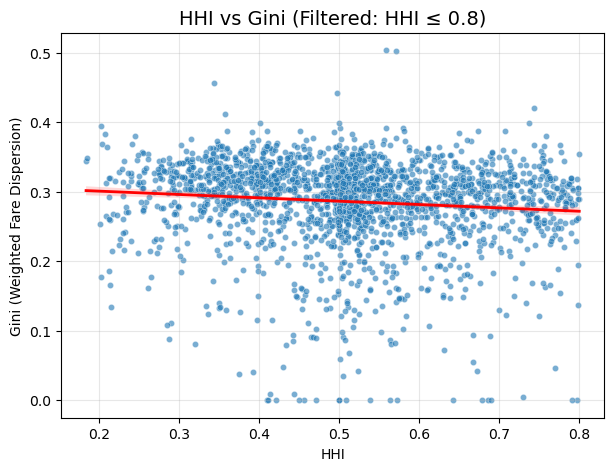

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_r2 = route_panel.copy()

df_r2 = df_r2.replace([np.inf, -np.inf], np.nan).dropna(subset=["HHI", "gini_route_weighted"])

df_r2 = df_r2[df_r2["HHI"] <= 0.8]

print("Remaining routes with HHI ≤ 0.8:", len(df_r2))

plt.figure(figsize=(7,5))

sns.scatterplot(
    x="HHI",
    y="gini_route_weighted",
    data=df_r2,
    s=20,
    alpha=0.6
)

sns.regplot(
    x="HHI",
    y="gini_route_weighted",
    data=df_r2,
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

plt.title("HHI vs Gini (Filtered: HHI ≤ 0.8)", fontsize=14)
plt.xlabel("HHI")
plt.ylabel("Gini (Weighted Fare Dispersion)")
plt.grid(alpha=0.3)

plt.show()


Total tickets on LAS–LAX (four carriers): 1280


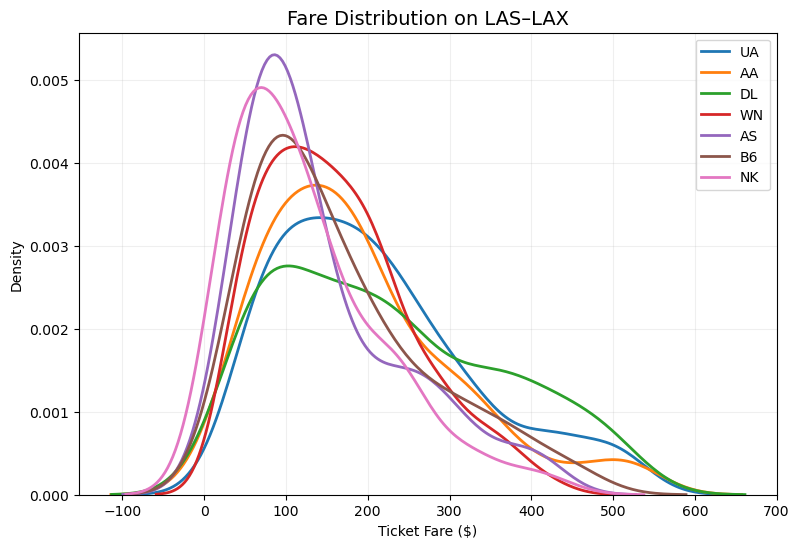

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# LAS → LAX
route_df = db1b_clean[
    (db1b_clean["ORIGIN_ROUTE"] == "LAS") &
    (db1b_clean["DEST_ROUTE"] == "LAX") &
    (db1b_clean["CARRIER"].isin(["UA","AA","DL","WN","AS","B6","NK"]))
].copy()

print("Total tickets on LAS–LAX (four carriers):", len(route_df))

#  KDE
plt.figure(figsize=(9,6))

sns.kdeplot(data=route_df[route_df["CARRIER"]=="UA"], x="FARE", label="UA", linewidth=2)
sns.kdeplot(data=route_df[route_df["CARRIER"]=="AA"], x="FARE", label="AA", linewidth=2)
sns.kdeplot(data=route_df[route_df["CARRIER"]=="DL"], x="FARE", label="DL", linewidth=2)
sns.kdeplot(data=route_df[route_df["CARRIER"]=="WN"], x="FARE", label="WN", linewidth=2)
sns.kdeplot(data=route_df[route_df["CARRIER"]=="AS"], x="FARE", label="AS", linewidth=2)
sns.kdeplot(data=route_df[route_df["CARRIER"]=="B6"], x="FARE", label="B6", linewidth=2)
sns.kdeplot(data=route_df[route_df["CARRIER"]=="NK"], x="FARE", label="NK", linewidth=2)

plt.title("Fare Distribution on LAS–LAX", fontsize=14)
plt.xlabel("Ticket Fare ($)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.2)

plt.show()


In [ ]:

df_big = route_panel[
    (route_panel["route_total_passengers"] >= 10_000) &
    (route_panel["n_carriers"] > 3)
].copy()


max_hhi = df_big["HHI"].max()


top_hhi_routes = df_big[df_big["HHI"] == max_hhi]

top_hhi_routes


,YEAR,QUARTER,ORIGIN_ROUTE,DEST_ROUTE,HHI,nonstop_miles,route_total_passengers,gini_route_weighted,avg_fare_per_mile_route,n_carriers,lat_org,lon_org,lat_dest,lon_dest
3142,2024,1,MSY,AUS,0.789399,444.0,43671.0,0.319974,0.503124,4.0,29.993401,-90.258003,30.1945,-97.669899


Tickets on MSY–AUS (AA/UA/WN): 171
CARRIER
WN    136
AA     30
UA      5
Name: count, dtype: int64


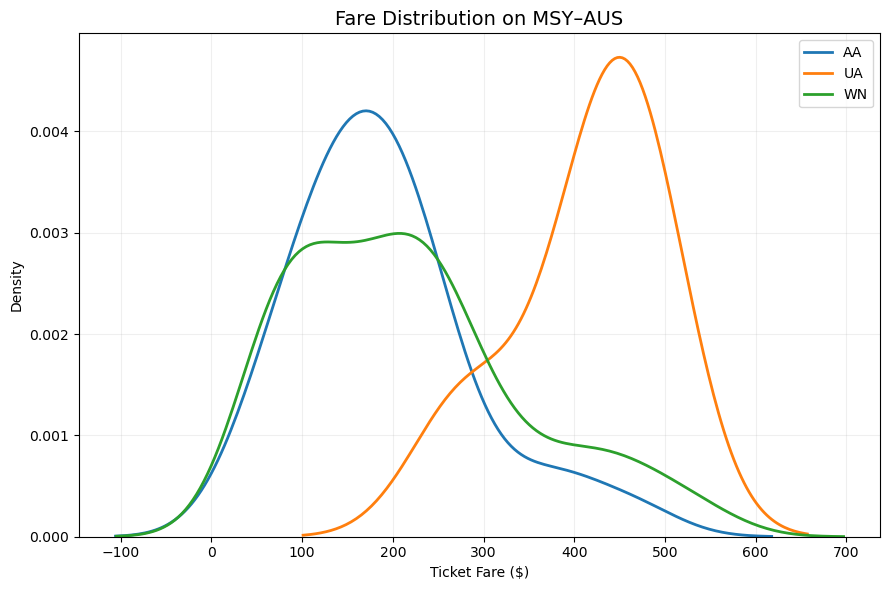

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# MSY → AUS, 2024 Q1, only AA / UA / WN
mask = (
    (db1b_clean["YEAR"] == 2024) &
    (db1b_clean["QUARTER"] == 1) &
    (db1b_clean["ORIGIN_ROUTE"] == "MSY") &
    (db1b_clean["DEST_ROUTE"] == "AUS") &
    (db1b_clean["CARRIER"].isin(["AA", "UA", "WN"]))
)
route_df = db1b_clean.loc[mask].copy()

fare_cap = route_df["FARE"].quantile(0.99)
route_df = route_df[route_df["FARE"] <= fare_cap].copy()

print("Tickets on MSY–AUS (AA/UA/WN):", len(route_df))
print(route_df["CARRIER"].value_counts())

plt.figure(figsize=(9, 6))

sns.kdeplot(data=route_df[route_df["CARRIER"] == "AA"], x="FARE", label="AA", linewidth=2)
sns.kdeplot(data=route_df[route_df["CARRIER"] == "UA"], x="FARE", label="UA", linewidth=2)
sns.kdeplot(data=route_df[route_df["CARRIER"] == "WN"], x="FARE", label="WN", linewidth=2)

plt.title("Fare Distribution on MSY–AUS", fontsize=14)
plt.xlabel("Ticket Fare ($)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()


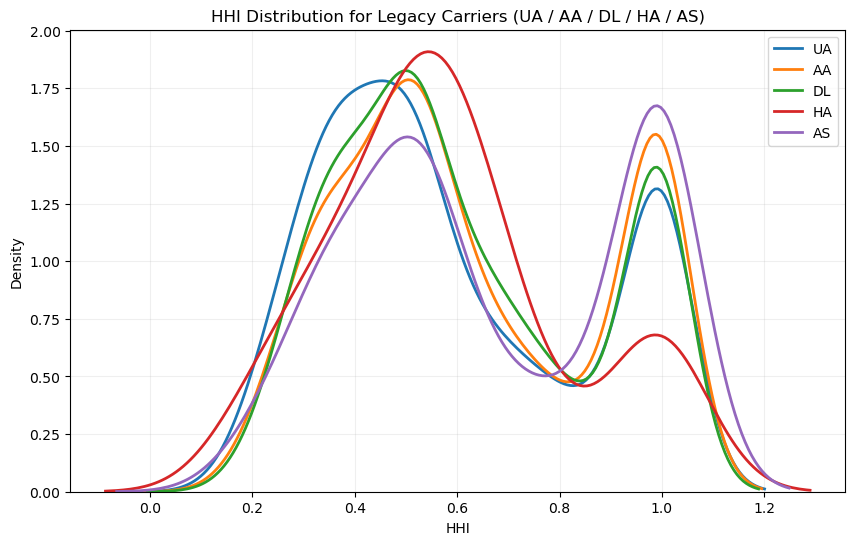

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

legacy = ["UA", "AA", "DL", "HA", "AS"]

df_legacy = (
    db1b_panel[
        db1b_panel["CARRIER"].isin(legacy)
    ][["CARRIER", "HHI"]]
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=["HHI"])
)

plt.figure(figsize=(10,6))

for c in legacy:
    subset = df_legacy[df_legacy["CARRIER"] == c]
    if len(subset) > 0:
        sns.kdeplot(subset["HHI"], label=c, linewidth=2)

plt.title("HHI Distribution for Legacy Carriers (UA / AA / DL / HA / AS)")
plt.xlabel("HHI")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


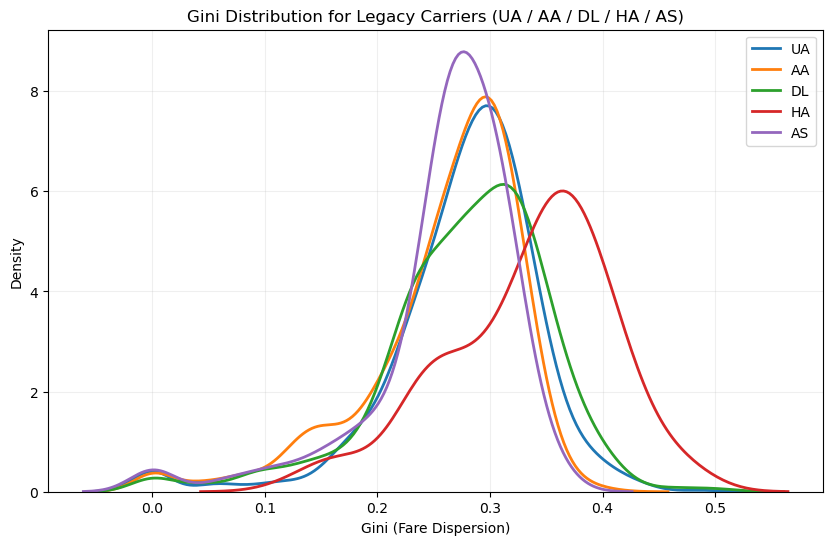

In [26]:
plt.figure(figsize=(10,6))

for c in legacy:
    subset = db1b_panel[
        (db1b_panel["CARRIER"] == c) &
        (db1b_panel["gini"].notna())
    ]
    if len(subset) > 0:
        sns.kdeplot(subset["gini"], label=c, linewidth=2)

plt.title("Gini Distribution for Legacy Carriers (UA / AA / DL / HA / AS)")
plt.xlabel("Gini (Fare Dispersion)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
